In [ ]:
!pip install fastapi ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
from fastapi import APIRouter, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse, JSONResponse
from fastapi.middleware.cors import CORSMiddleware
import cv2
import numpy as np
from ultralytics import YOLO
import logging
import io
import os
import base64
import math
import pandas as pd
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model = YOLO('yolo11n-pose.pt')

# SQUAT

In [ ]:
def calculate_angle(A, B, C):
    """
    Calculate the angle at joint B using three keypoints.
    """
    A, B, C = np.array(A[0:2]), np.array(B[0:2]), np.array(C[0:2])
    a = np.linalg.norm(B - C)
    b = np.linalg.norm(A - C)
    c = np.linalg.norm(A - B)
    return math.degrees(math.acos((a**2 + c**2 - b**2) / (2 * a * c)))

def analyze_squat(keypoints, df):
    """Analyze squat form using keypoints"""
    if not keypoints or len(keypoints) < 17:
        return ["Let's make sure your full body is visible in the camera."]

    try:
        rhip, rknee, rankle = keypoints[11], keypoints[13], keypoints[15]
        lhip, lknee, lankle = keypoints[12], keypoints[14], keypoints[16]
        rknee_angle = calculate_angle(rhip, rknee, rankle)
        lknee_angle = calculate_angle(lhip, lknee, lankle)

        rshoulder = keypoints[6]
        hip_angle = calculate_angle(rshoulder, rhip, [rhip[0], rhip[1] - 100, 0])
        shin_angle = calculate_angle(rankle, rknee, [rknee[0], rknee[1] + 100, 0])

        new_row = pd.DataFrame([{"Right Knee": rknee_angle, "Left Knee": lknee_angle, "Hip": hip_angle, "Shin": shin_angle}])
        df = pd.concat([df, new_row], ignore_index=True)
        return df
    except Exception as e:
        return df

In [ ]:
def draw_skeleton(frame, results, df):
    """Draw the skeleton on the frame"""
    try:
        for result in results:
            if result.keypoints is None or len(result.keypoints.data) == 0:
                continue

            # Draw keypoints
            keypoints = result.keypoints.data[0].cpu().numpy()

            print(keypoints.shape)

            # Draw skeleton lines
            skeleton = [[16,14],[14,12],[15,13],[11,13],[11,12],[6,12],[5,11],[5,6],[6,8],[8,10],[5,7],[7,9],
                        [2,4],[2,0],[0,1],[1,3]]

            df = analyze_squat(keypoints, df)
            print('result')
        print('try')

        return df
    except Exception as e:
        # Return original frame if drawing fails
        print('except')
        return df

In [ ]:
# Open video file
video_path = "test_squat.mov"  # Replace with your video path
cap = cv2.VideoCapture(video_path)

# Get video properties
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define output video writer
out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))



# generate data
df = pd.DataFrame(columns=["Right Knee", "Left Knee", "Hip", "Shin"])

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLO on frame
    results = model(frame)

    keypoints_list = []
    if len(results) > 0 and results[0].keypoints is not None:
        keypoints = results[0].keypoints.data[0].cpu().numpy().tolist()
        keypoints_list = keypoints

    df = analyze_squat(keypoints_list, df)

    # Write to output video
    out.write(frame)

    # Exit if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()


0: 640x384 1 person, 149.1ms
Speed: 3.6ms preprocess, 149.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)



<ipython-input-34-780cee3d9133>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


0: 640x384 1 person, 231.0ms
Speed: 3.6ms preprocess, 231.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 218.9ms
Speed: 4.7ms preprocess, 218.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 213.5ms
Speed: 4.3ms preprocess, 213.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 210.5ms
Speed: 5.1ms preprocess, 210.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 226.4ms
Speed: 4.8ms preprocess, 226.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 229.7ms
Speed: 4.3ms preprocess, 229.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 235.7ms
Speed: 4.2ms preprocess, 235.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 234.0ms
Speed: 4.9ms preprocess, 234.0ms inference, 1.6ms postprocess per image at 

In [ ]:
df

,Right Knee,Left Knee,Hip,Shin
0,168.806723,171.509977,6.080107,5.456322
1,168.609629,171.528470,6.163852,5.790268
2,168.175762,171.234501,5.111545,6.137692
3,168.312755,171.166996,5.873575,6.030185
4,168.598266,170.988582,6.223103,6.083064
...,...,...,...,...
396,154.625811,169.274383,18.752630,9.677685
397,155.032233,170.633137,17.104533,10.054637
398,159.018069,174.545999,15.561113,8.223701
399,161.844037,177.513480,14.286733,7.614368


# Visualization

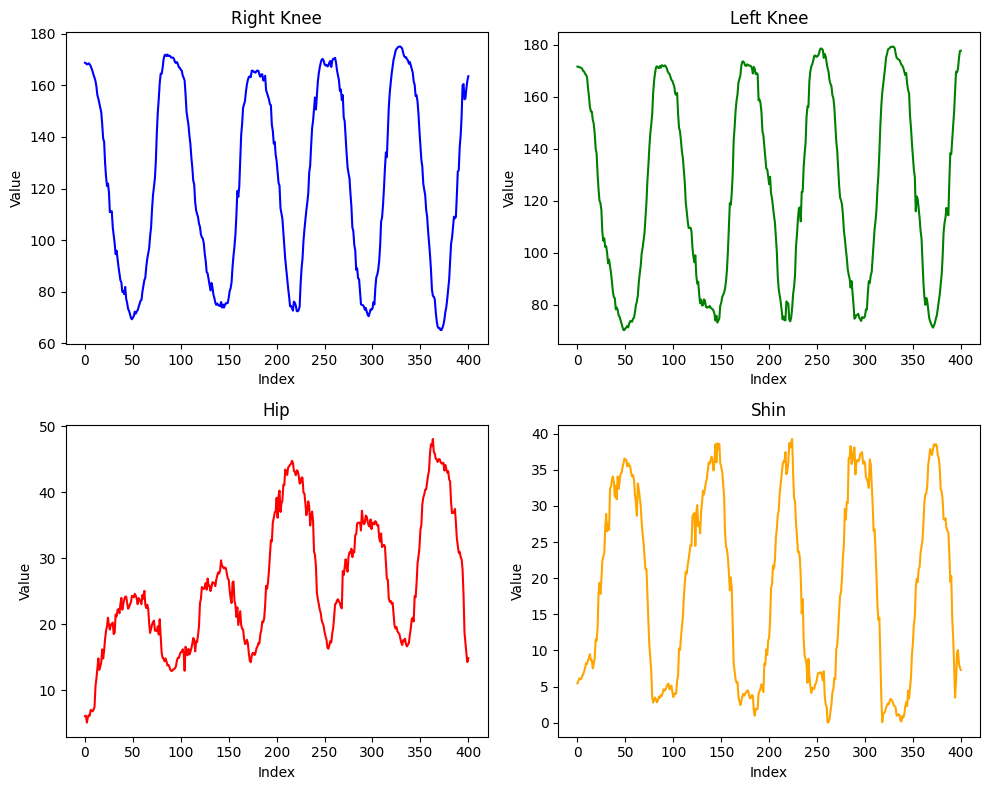

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot each column in a separate subplot
axs[0, 0].plot(df['Right Knee'], label='Right Knee', color='blue')
axs[0, 0].set_title('Right Knee')
axs[0, 0].set_xlabel('Index')
axs[0, 0].set_ylabel('Value')

axs[0, 1].plot(df['Left Knee'], label='Left Knee', color='green')
axs[0, 1].set_title('Left Knee')
axs[0, 1].set_xlabel('Index')
axs[0, 1].set_ylabel('Value')

axs[1, 0].plot(df['Hip'], label='Hip', color='red')
axs[1, 0].set_title('Hip')
axs[1, 0].set_xlabel('Index')
axs[1, 0].set_ylabel('Value')

axs[1, 1].plot(df['Shin'], label='Shin', color='orange')
axs[1, 1].set_title('Shin')
axs[1, 1].set_xlabel('Index')
axs[1, 1].set_ylabel('Value')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Calculate summary statistics: mean, min, and max for each column
mean_values = df.mean()
min_values = df.min()
max_values = df.max()

# Create a new DataFrame to store the statistics
df_stats = pd.DataFrame({
    'Mean': mean_values,
    'Min': min_values,
    'Max': max_values
})

# Display the summary statistics DataFrame
df_stats

,Mean,Min,Max
Right Knee,122.868252,65.076903,175.102891
Left Knee,124.634247,70.248752,179.246445
Hip,26.020636,5.111545,48.071441
Shin,18.735157,0.033399,39.244666


# PLANKS

In [ ]:
def analyze_plank(keypoints, df):
    """Analyze plank form using keypoints"""
    if not keypoints or len(keypoints) < 17:
        return ["Let's make sure your full body is visible in the camera."]

    try:
        shoulder = keypoints[5]  # right shoulder
        hip = keypoints[11]      # right hip
        knee = keypoints[13]     # right knee
        ankle = keypoints[15]    # right ankle

        leg_angle = calculate_angle(hip, knee, ankle)
        hip_angle = calculate_angle(shoulder, hip, knee)

        new_row = pd.DataFrame([{"Leg": leg_angle, "Hip": hip_angle}])
        df = pd.concat([df, new_row], ignore_index=True)

        return df
    except Exception as e:
        return df

In [ ]:
# Open video file
video_path = "test_plank.mov"  # Replace with your video path
cap = cv2.VideoCapture(video_path)

# Get video properties
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# generate data
df = pd.DataFrame(columns=["Leg", "Hip"])

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLO on frame
    results = model(frame)

    keypoints_list = []
    if len(results) > 0 and results[0].keypoints is not None:
        keypoints_list = results[0].keypoints.data[0].cpu().numpy().tolist()

    df = analyze_plank(keypoints_list, df)


0: 640x384 1 person, 153.8ms
Speed: 4.3ms preprocess, 153.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 151.5ms
Speed: 5.6ms preprocess, 151.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)



<ipython-input-76-e5ca413165d3>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


0: 640x384 1 person, 158.0ms
Speed: 4.9ms preprocess, 158.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 154.4ms
Speed: 5.6ms preprocess, 154.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 149.2ms
Speed: 6.1ms preprocess, 149.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 148.8ms
Speed: 5.1ms preprocess, 148.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 149.6ms
Speed: 4.1ms preprocess, 149.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 188.8ms
Speed: 4.2ms preprocess, 188.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 147.7ms
Speed: 5.7ms preprocess, 147.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 165.8ms
Speed: 4.9ms preprocess, 165.8ms inference, 1.2ms postprocess per image at 

In [ ]:
df

,Leg,Hip
0,157.354935,157.913959
1,158.496678,155.806643
2,159.596139,157.597226
3,159.351113,157.334013
4,157.354254,156.532804
...,...,...
472,147.591532,150.185918
473,146.884140,149.111694
474,146.021963,148.042226
475,145.286334,148.072744


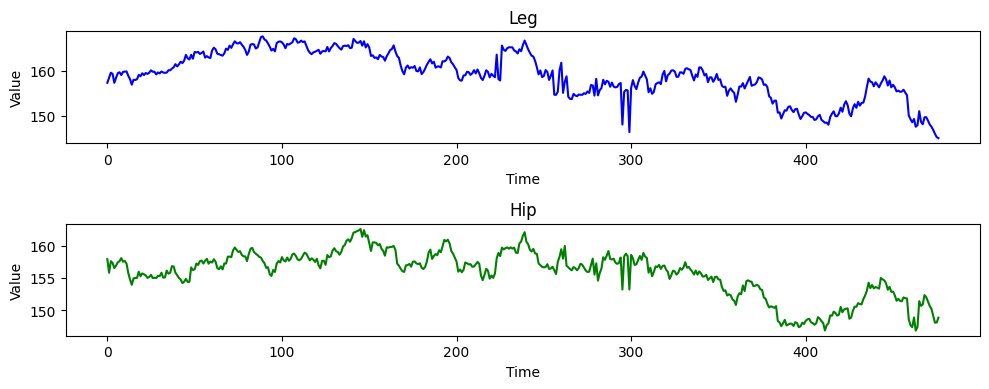

In [ ]:
fig, axs = plt.subplots(2, figsize=(10, 4))

# Plot each column in a separate subplot
axs[0].plot(df['Leg'], label='Leg', color='blue')
axs[0].set_title('Leg')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Value')

axs[1].plot(df['Hip'], label='Hip', color='green')
axs[1].set_title('Hip')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Value')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Calculate summary statistics: mean, min, and max for each column
mean_values = df.mean()
min_values = df.min()
max_values = df.max()

# Create a new DataFrame to store the statistics
df_stats = pd.DataFrame({
    'Mean': mean_values,
    'Min': min_values,
    'Max': max_values
})

# Display the summary statistics DataFrame
df_stats

,Mean,Min,Max
Leg,159.038675,145.057767,167.665234
Hip,155.710909,146.805969,162.620950


# ARM RAISES

In [ ]:
def analyze_arm_raise(keypoints, df):
    """Analyze arm raise form using keypoints"""
    if not keypoints or len(keypoints) < 17:
        return df
    try:
        rshoulder, relbow, rwrist, rhip = keypoints[5], keypoints[7], keypoints[9], keypoints[11]
        lshoulder, lelbow, lwrist, lhip = keypoints[6], keypoints[8], keypoints[10], keypoints[12]
        neck = keypoints[0]  # Use neck as reference for shoulder alignment

        if any(keypoint[0:2] == [0, 0] for keypoint in [rshoulder, relbow, rwrist, lshoulder, lelbow, lwrist, rhip, lhip]):
            return df

        # Check arm extension angles
        rarm_angle = calculate_angle(rhip, rshoulder, relbow)
        larm_angle = calculate_angle(lhip, lshoulder, lelbow)

        # Check shoulder elevation (arms relative to neck)
        r_shoulder_height = calculate_angle(neck, rshoulder, rwrist)
        l_shoulder_height = calculate_angle(neck, lshoulder, lwrist)

        new_row = pd.DataFrame([{"Right Arm": rarm_angle, "Left Arm": larm_angle, "Right Shoulder": r_shoulder_height, "Left Shoulder": l_shoulder_height}])
        df = pd.concat([df, new_row], ignore_index=True)

        return df
    except Exception as e:
        return df

In [ ]:
# Open video file
video_path = "test_armraises.mov"  # Replace with your video path
cap = cv2.VideoCapture(video_path)

# Get video properties
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# generate data
df = pd.DataFrame(columns=["Right Arm", "Left Arm", "Right Shoulder", "Left Shoulder"])

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLO on frame
    results = model(frame)

    keypoints_list = []
    if len(results) > 0 and results[0].keypoints is not None:
        keypoints_list = results[0].keypoints.data[0].cpu().numpy().tolist()

    df = analyze_arm_raise(keypoints_list, df)


0: 640x384 1 person, 155.1ms
Speed: 4.6ms preprocess, 155.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 137.1ms
Speed: 3.6ms preprocess, 137.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)



<ipython-input-90-85469df86239>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


0: 640x384 1 person, 145.7ms
Speed: 4.0ms preprocess, 145.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 136.6ms
Speed: 3.7ms preprocess, 136.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 138.0ms
Speed: 3.4ms preprocess, 138.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 158.0ms
Speed: 3.7ms preprocess, 158.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 140.0ms
Speed: 6.4ms preprocess, 140.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 141.2ms
Speed: 3.2ms preprocess, 141.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 142.9ms
Speed: 4.0ms preprocess, 142.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 153.9ms
Speed: 3.6ms preprocess, 153.9ms inference, 1.1ms postprocess per image at 

In [ ]:
df

,Right Arm,Left Arm,Right Shoulder,Left Shoulder
0,99.192409,98.695101,130.375631,131.843909
1,96.535675,97.036623,132.169665,132.514285
2,91.543721,92.636651,137.127600,136.070899
3,87.430276,89.985235,140.947153,137.951803
4,83.703027,85.035336,146.427217,141.343281
...,...,...,...,...
480,88.697070,90.809781,135.612058,131.509782
481,88.798591,88.953529,137.043319,133.370256
482,86.661412,87.566330,138.859656,135.211163
483,88.009347,90.734306,137.875383,142.078620


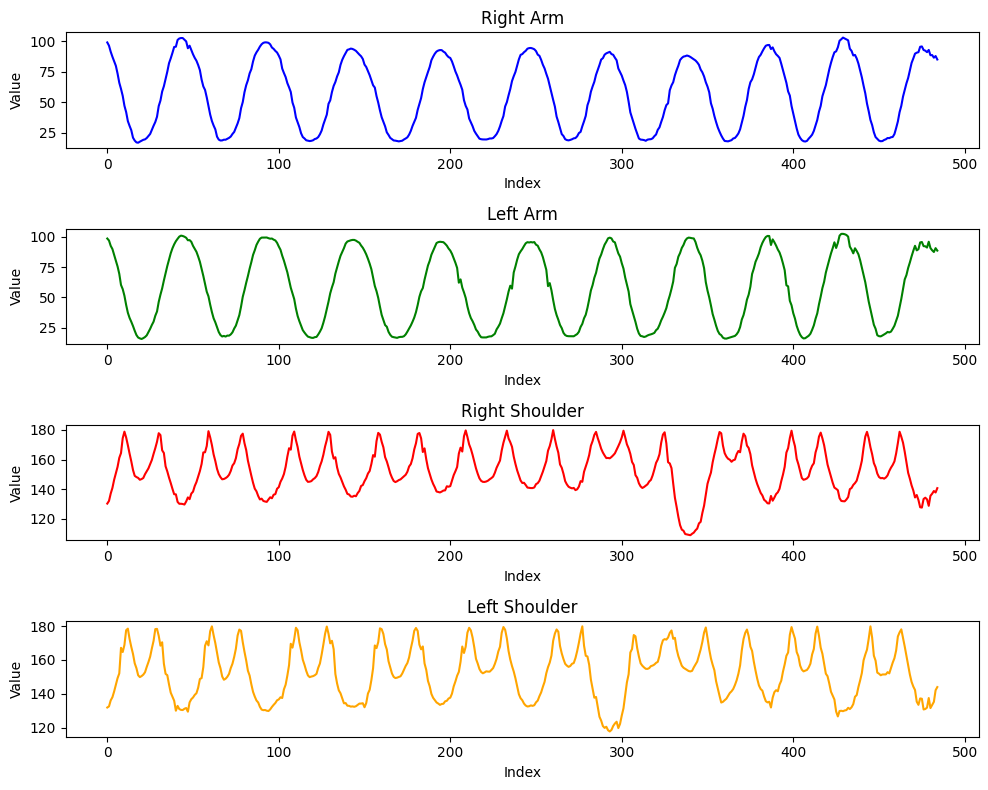

In [ ]:
fig, axs = plt.subplots(4, figsize=(10, 8))

# Plot each column in a separate subplot
axs[0].plot(df['Right Arm'], label='Right Knee', color='blue')
axs[0].set_title('Right Arm')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')

axs[1].plot(df['Left Arm'], label='Left Knee', color='green')
axs[1].set_title('Left Arm')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')

axs[2].plot(df['Right Shoulder'], label='Right Shoulder', color='red')
axs[2].set_title('Right Shoulder')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Value')

axs[3].plot(df['Left Shoulder'], label='Left Shoulder', color='orange')
axs[3].set_title('Left Shoulder')
axs[3].set_xlabel('Index')
axs[3].set_ylabel('Value')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Calculate summary statistics: mean, min, and max for each column
mean_values = df.mean()
min_values = df.min()
max_values = df.max()

# Create a new DataFrame to store the statistics
df_stats = pd.DataFrame({
    'Mean': mean_values,
    'Min': min_values,
    'Max': max_values
})

# Display the summary statistics DataFrame
df_stats

,Mean,Min,Max
Right Arm,57.089440,16.824110,103.170819
Left Arm,57.686689,15.584824,102.571079
Right Shoulder,152.475257,109.060879,179.907898
Left Shoulder,152.594335,117.664883,179.904736
